##### Copyright 2020 The TensorFlow Authors.

In [11]:
from IPython import display

import glob
import imageio
import PIL
import time
import json
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
# tf.debugging.set_log_device_placement(True)

## Load the ACDC dataset

Actually each patient in the ACDC dataset is a 4D volume (3 spatial dimension and one temporal one), where the myocard, richt and left ventricle are segmented in 2 time steps (end systolic (ES) and end diastolic (ED)). For an easier network structure and less memory requirements, the segmented time steps are sliced into 2D slices to be processed by the network. This was done beforehand and the resulting numpy vectors can be downloaded from [here](). Fruther, a "D reshaping to 256x256 pixels was done beforehand to save all images in one big array.

In [2]:
dataset = np.load("acdc_data/acdc_data_one_hot.npz")
train_images = dataset["train_imgs"].astype(np.float32)
train_labels = dataset["train_labels"]
test_images = dataset["test_imgs"].astype(np.float32)
test_labels = dataset["test_labels"]

with open('acdc_data/label_assignment.json') as f:
    label_assignment = json.load(f)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images))
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(len(test_images))
label_assignment

2022-01-04 10:43:58.384982: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-04 10:43:58.408066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 10:43:58.408466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-04 10:43:58.408478: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-04 10:43:58.409395: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-04 10:43:58.410321: I tensorflow/stream_executor/platform/default/

{'0': 'DCM', '1': 'HCM', '2': 'MINF', '3': 'NOR', '4': 'RV'}

Why no preprocessing here?

In [3]:
def downsampling_block(filters: int) -> tfk.Sequential:
    return tfk.Sequential([
        tfkl.Conv2D(filters=filters, kernel_size=3, strides=2, activation='relu'),
        tfkl.Conv2D(filters=filters, kernel_size=3, strides=1, activation='relu', padding='same')
    ])

def upsampling_block(filters: int) -> tfk.Sequential:
    return tfk.Sequential([
        tfkl.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2DTranspose(filters=filters, kernel_size=3, strides=1, activation='relu', padding='same')
    ])

class CVAE(tfk.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, 
                 latent_dim: int, 
                 filters: List[int] = [32, 64],
                 n_classes: int = 1,
                 input_shape: Tuple[int, int, int] = (28, 28, 1)):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        enc_convs = [downsampling_block(f) for f in filters]
        dec_convs = [upsampling_block(f) for f in filters]
        self.encoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=input_shape),
            *enc_convs,
            tfkl.Flatten(),
            # No activation
            tfkl.Dense(latent_dim + latent_dim),
        ])
        
        h = w = int(input_shape[0] / 2**len(filters))
        self.decoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=(latent_dim,)),
            tfkl.Dense(units=h*w*32, activation=tf.nn.relu),
            tfkl.Reshape(target_shape=(h, w, 32)),
            *dec_convs,
            # No activation
            tfkl.Conv2D(filters=n_classes, kernel_size=3, strides=1, padding='same'),
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        z = eps * tf.exp(logvar * .5) + mean
        return z, mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            if self.n_classes == 1:
                probs = tf.sigmoid(logits)
            else:
                probs = tf.math.argmax(tf.nn.softmax(logits), axis=-1)
            return probs
        return logits

In [4]:
def log_normal_pdf(sample: tf.Tensor, mean: tf.Tensor, logvar: tf.Tensor, raxis: int = 1) -> tf.Tensor:
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def kl_divergence(mean: tf.Tensor, sd: tf.Tensor) -> tf.Tensor:
    return - 0.5 * tf.reduce_sum(
            1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mean) - tf.math.square(sd),
            axis=1)

def compute_loss(model: tfk.Model, 
                 x: tf.Tensor, 
                 loss: str = "cross_entropy", 
                 analytic_kl: bool = False, 
                 beta: float = 1.) -> Tuple[tf.Tensor, ...]:

    # forward pass
    z, mean, logvar = model.encode(x)
    x_logit = model.decode(z)
    
    # compute neg log likelihood
    if loss == "cross_entropy":
        cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])#, 3])
    elif loss == "mse":
        logpx_z = tf.reduce_mean((x - x_logit)**2 / np.prod(x.shape), axis=[1, 2])#, 3])
        
    # compute kl divergence
    if analytic_kl:
        sd = tf.exp(logvar * .5)
        kl_div = kl_divergence(mean, sd)
    else:
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        kl_div = logpz - logqz_x
    kl_div *= beta
    
    return -tf.reduce_mean(logpx_z + kl_div), logpx_z, kl_div

@tf.function
def train_step(model: tfk.Model, 
               x: tf.Tensor, 
               optimizer: tfk.optimizers.Optimizer, 
               loss: str = "cross_entropy",
               analytic_kl: bool = False,
               beta: float = 1.) -> Tuple[tf.Tensor, ...]:
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        elbo, nll, kl_div = compute_loss(model, x)
    gradients = tape.gradient(elbo, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return elbo, nll, kl_div

# Hyperparameter

### Questions

Why higher latent dim?

Why is cross entropy better suited as loss function in this case?

In [5]:
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-3
LATENT_DIM = 10
LOSS = "cross_entropy"
ANALYTIC_KL = True
BETA = 1.
FILTERS = [32, 64, 64]
N_CLASSES = 4
INPUT_SHAPE = (256, 256, N_CLASSES)

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
num_examples_to_generate = 16

In [6]:
model = CVAE(LATENT_DIM, filters=FILTERS, input_shape=INPUT_SHAPE, n_classes=N_CLASSES)
optimizer = tfk.optimizers.Adam(LR)

In [7]:
def from_one_hot(img_one_hot: np.ndarray) -> np.ndarray:
    img = np.zeros(img_one_hot.shape[:-1])
    for i in range(img_one_hot.shape[-1]):
        img[img_one_hot[...,i].astype(bool)] = i
    return img

def plot_test_sample(test_sample: tf.Tensor) -> None:
    if not isinstance(test_sample, np.ndarray):
        test_sample = test_sample.numpy()
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :], cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def generate_images(model: tfk.Model, test_sample: tf.Tensor) -> None:
    z, mean, logvar = model.encode(test_sample)
    predictions = model.sample(z)
    plot_test_sample(predictions)

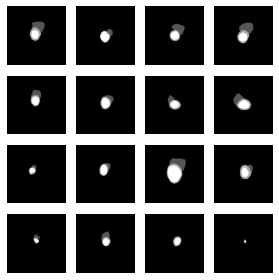

In [8]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
plot_test_sample(from_one_hot(test_sample.numpy()))

Epoch: 20, Test set ELBO: 1982.44, time elapse for current epoch: 3.89


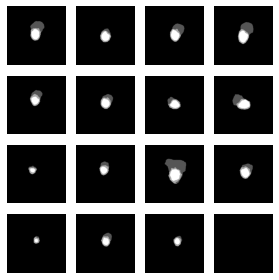

In [9]:
generate_images(model, test_sample)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    for train_x in train_dataset:
        elbo, nll, kl_div = train_step(model, train_x, optimizer, loss=LOSS, analytic_kl=ANALYTIC_KL, beta=BETA)
    end_time = time.time()

    for test_x in test_dataset:
        elbo, nll, kl_div = compute_loss(model, test_x, loss=LOSS, analytic_kl=ANALYTIC_KL, beta=BETA)

    display.clear_output(wait=False)
    print(f'Epoch: {epoch}, Test set ELBO: {elbo.numpy():.2f}, time elapse for current epoch: {end_time - start_time:.2f}')
    generate_images(model, test_sample)

### Display the structure of the latent space

We explore the different clusters that are formed in latent space during training. Because our latent space has $\mathrm{dim} \geq 2$, we must use a dimensionality reduction technique to project to 2 dimensions for which ussually t-SNE is used.

In [15]:
from sklearn.manifold import TSNE

def plot_latent_space(model: tfk.Model, test_images: np.ndarray, test_labels: np.ndarray, label_assignment: Optional[Dict[int, str]] = None) -> None:
    zs = np.array([model.encode(test_x[None,...,None])[0].numpy()[0].tolist() for test_x in test_images])
    if zs.shape[-1] > 2: # check if latent_dim > 2 -> dimensionality reduction with tsne for plotting purposes
        tsne = TSNE()
        zs = tsne.fit_transform(zs)
    zs = {n: zs[test_labels == n] for n in range(int(test_labels.max() + 1))}
    for n, zs_n in zs.items():
        label = label_assignment[str(n)] if label_assignment is not None else n
        plt.scatter(zs_n[:,0], zs_n[:,1], label=label)
    plt.legend()
    plt.show()

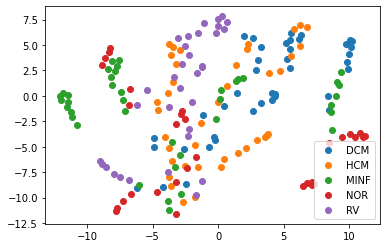

In [16]:
plot_latent_space(model, test_images, test_labels, label_assignment)